# Image classification: dogs & cats

In [1]:
# Handle imports up-front
import os
import glob
from typing import Tuple

# Silence info. messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image

## 1. Data preparation

### 1.1. Load the data paths

In [9]:
# Set the path to the training data
training_data_path = '../data/images/training'
validation_data_path = '../data/images/validation'

# Get a list of training dog and cat images
training_dogs = glob.glob(f'{training_data_path}/dogs/dog.*')
training_cats = glob.glob(f'{training_data_path}/cats/cat.*')
validation_dogs = glob.glob(f'{validation_data_path}/dogs/dog.*')
validation_cats = glob.glob(f'{validation_data_path}/cats/cat.*')

### 1.2. Inspect

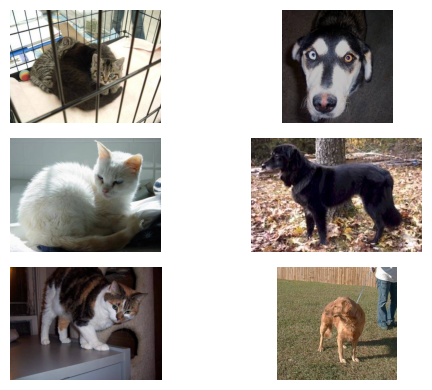

In [10]:
fig, axs = plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 2. EDA

Let's take a look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [11]:
# Load one of the images as an array and look at it's shape - what do you see, what are the dimensions? Are they what you expect?

In [12]:
# Plot a histogram of the three 2D arrays which comprise the image. What do you see?

### 2.2. Image dimensions

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

In [13]:
# Loop over a few hundred images and extract their width and heigh, plot both as a histogram. What do you see, does this information matter to us, if so, how?

### 2.3. Image aspect ratios

In [14]:
# Plot a histogram of the image aspect ratios (i.e. width/height) What do you see, does this information matter to us, if so, how?

## 3. Build the model

### 3.1. Prepare images for streaming

In [16]:
def make_datasets(
        training_data_path: str,
        validation_data_path: str,
        image_width: int,
        image_height: int, 
        batch_size: int=32,
        steps_per_epoch: int=50,
        epochs: int=10
) -> Tuple[tf.data.Dataset, tf.data.Dataset]:

    training_dataset = tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        seed=315,
        shuffle=True,
        image_size=(image_width, image_height),
        batch_size=batch_size
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        validation_data_path,
        seed=315,
        shuffle=True,
        image_size=(image_width, image_height),
        batch_size=batch_size
    )

    epoch_images = batch_size*steps_per_epoch
    total_images = epoch_images*epochs

    training_dataset = training_dataset.cache().shuffle(total_images, reshuffle_each_iteration=True).prefetch(buffer_size=total_images).repeat()
    validation_dataset = training_dataset.cache().shuffle(total_images, reshuffle_each_iteration=True).prefetch(buffer_size=total_images).repeat()

    return training_dataset, validation_dataset


training_dataset, validation_dataset = make_datasets(
    training_data_path,
    validation_data_path,
    image_width=64,
    image_height=48,
    batch_size=64,
    steps_per_epoch=50,
    epochs=100
)

Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


### 3.1. Model definition

In [ ]:
def compile_model(image_width, image_height, learning_rate):

    initializer=tf.keras.initializers.GlorotUniform(seed=315)

    model=Sequential([
        layers.Input((image_width, image_height, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

    return model


model = compile_model(
    image_width=64,
    image_height=48, 
    learning_rate=0.1
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,057 (1.59 MB)

 Trainable params: 417,057 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2. Model training

In [18]:
%%time

training_results = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=100,
  steps_per_epoch=50,
  validation_steps=50,
  verbose=0
)

print()


CPU times: user 24min 49s, sys: 1min 28s, total: 26min 18s
Wall time: 15min 51s


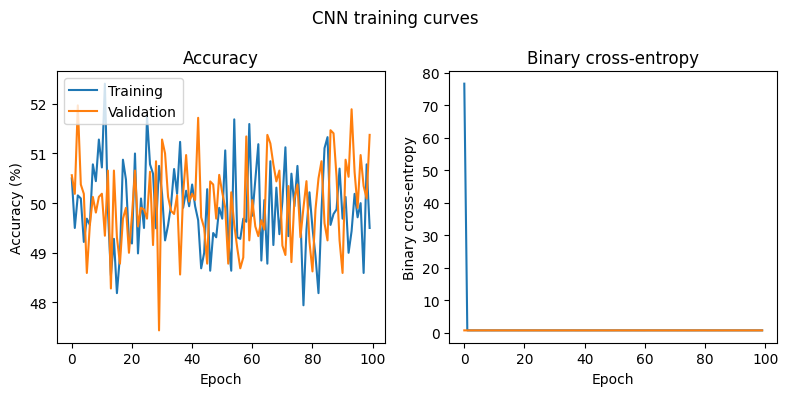

In [19]:
# Take a look the information 'training_results' contains. Plot the training 
# and validation accuracy (and binary cross-entropy if you like) over the
# training epochs. Is the model learning? If not, what do you think
# is wrong?
 
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves', size='large')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_results.history['binary_accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_results.history['val_binary_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_results.history['loss'])
axs[1].plot(training_results.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

# Show the plot
fig.tight_layout()

### 3.3. Model optimization

In [ ]:
# Try optimizing the learning rate and the batch size using a few values near the default settings. Hint: use a loop!

In [ ]:
# Pick the best values for learning rate and batch size and train the model for longer

## 4. Evaluate the model

In [ ]:
# Test the model out on the test data - is it as good as you expected, given the training data? Worse? Better? Why?